<a href="https://colab.research.google.com/github/wadeaT/Cloud-Computing-Course/blob/main/Project/searchEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Panther Search! 🐾

This Google Collab notebook is your gateway to exploring our innovative search engine based on RedHat website. Dive into a world of seamless search functionality, enhanced ChatBot capabilities, and more! 🚀

Instructions:

* Optional: For the best visual experience we suggest you to switch to dark mode in Google Collab
* Click on Runtime -> Run all (Ctrl + F9)
*   Scroll down to the bottom of the notebook
*   Find the following page: 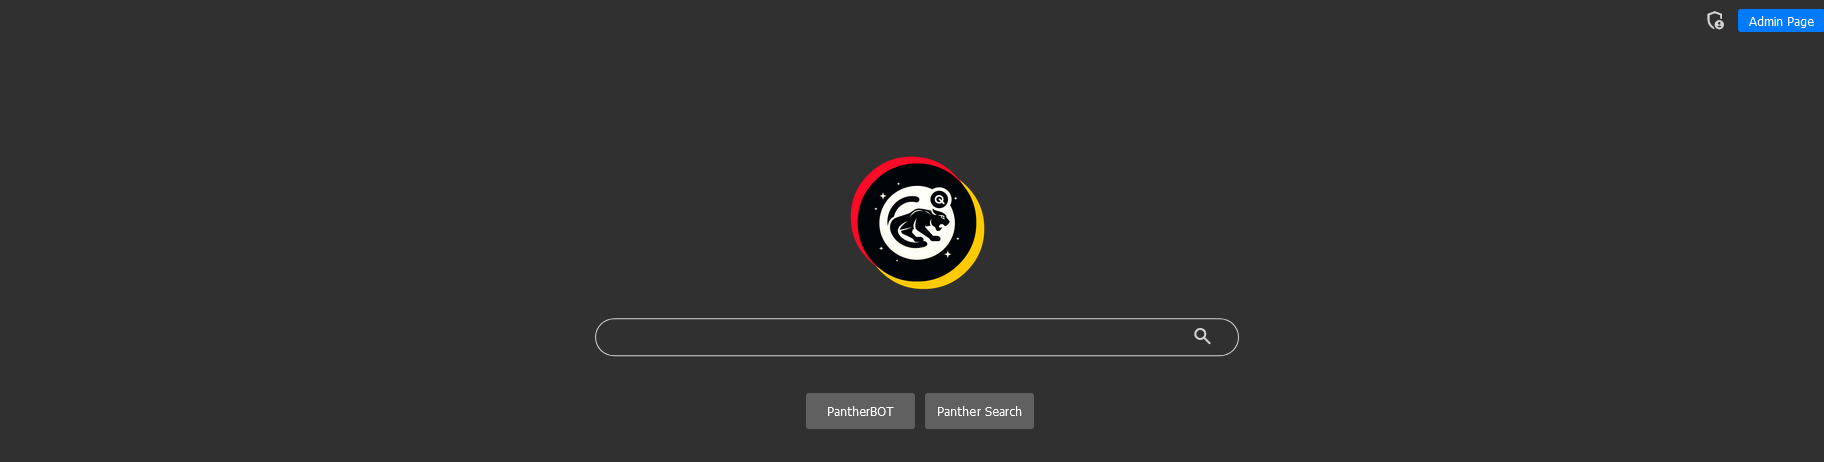
* Enjoy!

In [ ]:
!pip install requests beautifulsoup4
!pip install firebase
!pip install firebase-admin

In [ ]:
from google.colab import drive, output
from IPython.display import HTML, Javascript
from IPython.display import clear_output
from firebase_admin import credentials
from firebase_admin import firestore
from nltk.chat.util import Chat, reflections
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import firebase_admin
import IPython
import random
import json
import os
import re
import requests
import nltk

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Github connection

In [ ]:
# Specify the directory path
directory = '/content/CloudComputing-tirgul'

# Check if the directory exists
if os.path.exists(directory):
    # If the directory exists, remove it recursively
    !rm -r "$directory"

# Change the current directory to /content
os.chdir('/content')

# Clone the GitHub repository
!git clone "https://github.com/ndvp39/CloudComputing-tirgul"

# drive.mount('/content/drive')

Cloning into 'CloudComputing-tirgul'...
remote: Enumerating objects: 1007, done.
remote: Counting objects: 100% (1007/1007), done.
remote: Compressing objects: 100% (537/537), done.
remote: Total 1007 (delta 633), reused 707 (delta 425), pack-reused 0
Receiving objects: 100% (1007/1007), 11.62 MiB | 21.10 MiB/s, done.
Resolving deltas: 100% (633/633), done.


Index:

In [ ]:
# Run the index.ipynb notebook
%cd /content/CloudComputing-tirgul/Project/Index/
%run index.ipynb

/content/CloudComputing-tirgul/Project/Index


Get index from db

In [ ]:
# GET INDEX FROM DB
index = get_index_from_db()

ChatBot

In [ ]:
# Run the chatbot.ipynb notebook
%cd /content/CloudComputing-tirgul/Project/Chatbot/
%run chatbot.ipynb

/content/CloudComputing-tirgul/Project/Chatbot
/content/CloudComputing-tirgul/Project/Index


In [ ]:
# Retrieve chatbot patterns from the database
db_collection_name = "ChatBotPatterns"
chatbot_patterns = get_patterns_from_db(db_collection_name)

# Create a new chatbot instance using the retrieved patterns and reflections
chatbot = Chat(chatbot_patterns, reflections)


SearchEngine

In [ ]:
# Load and display a web page.
# Display HTML with optional CSS and JavaScript
# Supports two types of HTML docs - 1. combined with css and js | 2. 3 separate files
def switchToScreen(css_filename_, html_filename_, js_filename_):
    clear_output(wait=True) # Clear the current output to display the new content

    if css_filename_ is None and js_filename_ is None:
        html_response = requests.get(html_filename_)
        html_content_ = html_response.text
        display(HTML(html_content_))
    else:
        css_response = requests.get(css_filename_)
        css_content_ = css_response.text
        display(HTML(f'<style>{css_content_}</style>'))

        html_response = requests.get(html_filename_)
        html_content_ = html_response.text
        display(HTML(html_content_))

        js_response = requests.get(js_filename_)
        js_content_ = js_response.text
        display(Javascript(js_content_))

In [ ]:
# Extract title from the HTML content of a given link.
def get_title_from_link(link):
    try:
        # Make an HTTP request
        response = requests.get(link)

        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Parse the HTML content
            soup = BeautifulSoup(response.text, 'html.parser')

            # Find the <h1> tag
            h1_tag = soup.find('h1')
            if h1_tag:
                return h1_tag.get_text()
            else:
                # If <h1> tag not found, try <h2> tag
                h2_tag = soup.find('h2')
                if h2_tag:
                    return h2_tag.get_text()
        else:
            # Return error message if request fails
            return f"Failed to fetch the page. Status code: {response.status_code}"

    except Exception as e:
        # Return error message if any exception occurs during extraction
        return f"An error occurred: {e}"

In [ ]:
# Sort the links for the given words in order to present more relevant results.
def extract_sorted_links(word):
  return sorted(index[word].items(), key = lambda x: x[1]['counter'], reverse = True)


In [ ]:


# Check for duplicate titles in a list and append index if found.
def check_title_list(lst):
  seen = {}
  result = []
  for word in lst:
    word = re.sub(r'\s{2,}', ' ', word).strip()
    if word not in seen:
      seen[word] = 1
      result.append(word)
    else:
      seen[word] += 1
      result.append(f"{word}_{seen[word] - 1}")
  return result


# Retrieve titles, links, and query count for a given search string.
def get_titles_links_of_search(search_string):
  query_counter = 0
  titles = list()
  links = []
  texts = []
  # RedHat is split into two strings so insuring that results are found for this string.
  search_string = search_string.split()
  if "redhat" in search_string:
    search_string.append("red")
    search_string.append("hat")
  # trimming and steaming algorithem to search terms exactly as they are in the DB
  search_string = remove_stop_words(search_string, False)
  search_string = trim_words(search_string)
  search_string = apply_stemming(search_string)
  for word in index.keys():
    if word in search_string:
      extracted_links = extract_sorted_links(word)
      for i in range(min(10, len(extracted_links))): # 10 results max
        curr_link = extracted_links[i][0]
        query_counter += index[word][curr_link]['counter']
        if curr_link not in links:
          temp_title = get_title_from_link(curr_link)
          if "An error occurred" not in temp_title and "intcmp" not in curr_link:
            titles.append(temp_title)
            links.append(curr_link)
            texts.append(get_first_paragraph_from_link(curr_link).replace("\"", ''))
  titles = check_title_list(titles)
  return titles, links, texts, query_counter

In [ ]:
# Process the received search string and display search results in the GUI
def receive_search_string(search_string):

  # If search string is empty, return
  if search_string.strip() == "":
    return

  # Store original search string before modification
  original_search_string = search_string
  search_string = search_string.lower()

  # Random messages to display to the user when searching.
  loading_messages = [
    "Hold tight! Panther is generating your results...",
    "Hang on! Panther is working on your search...",
    "Patience, please! Panther is fetching your results...",
    "Just a moment! Panther is scouring the web for you..."
  ]

  # Randomly select a loading message
  loading_string = random.choice(loading_messages)

  # Switch to the results screen
  html_filename = f"https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/results.html"
  js_filename = f"https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/script.js"
  switchToScreen(css_filename, html_filename, js_filename)

  # JavaScript code to set the search bar text
  js_code = f"""
    <script>
      document.getElementById("searchbartext").value = "{original_search_string}";
      document.getElementById("loading").innerHTML = "{loading_string}"
    </script>
    """
  display(HTML(js_code))
  # Retrieve search results
  titles, links, texts, times_appeared = get_titles_links_of_search(search_string)

  # Convert Python arrays to JavaScript arrays
  titles_js_array = ', '.join(f'"{title}"' for title in titles)
  links_js_array = ', '.join(f'"{link}"' for link in links)
  texts_js_array = ', '.join(f'"{text}"' for text in texts)
  times_appeared_str = str(times_appeared)

  # JavaScript code to render search results
  js_code_2 = f"""
    <script>
      document.getElementById("loading").innerHTML = ""
      renderResults_title_link([ {titles_js_array} ], [ {links_js_array} ], [ {texts_js_array} ], [{times_appeared_str}]);
    </script>
  """

  display(HTML(js_code_2))

  # Update statistics if search results are available
  if titles:
    update_or_add_statistic(search_string)

# Register the function to be called from JavaScript
output.register_callback('notebook.receive_search_string', receive_search_string)

# Switch to the home page of the GUI.
def back_to_home_page():
  html_filename = f"https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/index.html"
  switchToScreen(css_filename, html_filename, js_filename)

# Register the function to be called from JavaScript
output.register_callback('notebook.back_to_home_page', back_to_home_page)


In [ ]:
# Switch to the chatbot page of the GUI
def open_chatbot_page():
  html_filename = f"https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/chatbot.html"
  switchToScreen(css_filename, html_filename, js_filename)

# Register the function to be called from JavaScript
output.register_callback('notebook.open_chatbot_page', open_chatbot_page)

# Receive a question from the chatbot interface and provide a response
def receive_question_chatbot(question):
  empty_string = False

  if question == "":
    empty_string = True

  # Get response from the chatbot
  response = chatbot.respond(question)

  if response is None:
    response = "I'm unable to generate a response to that question. Is there anything else I can assist you with?"

  # A case for empty string search.
  if empty_string:
    response = "It seems like your message is blank. How can I assist you today? If you have any questions or need assistance, feel free to ask!"

  # Generate JavaScript code to display the chatbot response
  js_code = f"""
      <script>
        ChatbotResponse("{response}");
      </script>
    """

  display(HTML(js_code))

# Register the function to be called from JavaScript
output.register_callback('notebook.receive_question_chatbot', receive_question_chatbot)

In [ ]:
# Switch to the indexeditor page
def open_indexeditor_page():
  html_filename = "https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/admin.html"
  switchToScreen(None, html_filename, None)

# Register the function to be called from JavaScript
output.register_callback('notebook.open_indexeditor_page', open_indexeditor_page)

# Switch to the statistics page
def open_statistics_screen():
  html_filename = "https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/statistics.html"
  switchToScreen(None, html_filename, None)

# Register the function to be called from JavaScript
output.register_callback('notebook.open_statistics_screen', open_statistics_screen)

# Switch to the admin page
def back_to_admin():
  html_filename = "https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/admin.html"
  switchToScreen(None, html_filename, None)

# Register the function to be called from JavaScript
output.register_callback('notebook.back_to_admin', back_to_admin)


Administration:

In [ ]:
# Run the administration.ipynb notebook
%cd /content/CloudComputing-tirgul/Project/Administration/
%run administration.ipynb

/content/CloudComputing-tirgul/Project/Administration
/content/CloudComputing-tirgul/Project/Index


Loading the main page

In [1]:
css_filename = f"https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/style.css"
js_filename = f"https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/script.js"
html_filename = f"https://raw.githubusercontent.com/ndvp39/CloudComputing-tirgul/main/Project/GUI/index.html"
switchToScreen(css_filename, html_filename, js_filename)

#========================#
#                        #
# ADMIN PASSWORD: 123456 #
#                        #
#========================#

NameError: name 'switchToScreen' is not defined